In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from torchvision.utils import save_image

In [62]:
!git clone https://github.com/s295103/invertinggradients.git
%cd invertinggradients/

Cloning into 'invertinggradients'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 118 (delta 39), reused 31 (delta 29), pack-reused 57
Receiving objects: 100% (118/118), 2.54 MiB | 12.08 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/invertinggradients/invertinggradients/invertinggradients


# Choose variants here:

In [63]:
arch = 'ResNet20'
num_images = 2
trained_model = False

## System setup:

In [64]:
import inversefed
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR100', defs)

model, _ = inversefed.construct_model(arch, num_classes=100, num_channels=3)
model.to(**setup)
if trained_model:
    epochs = 120
    file = f'{arch}_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

Currently evaluating -------------------------------:
Monday, 15. May 2023 06:32PM
CPUs: 1, GPUs: 1 on 170aa3096b1f.
GPU : Tesla T4
Files already downloaded and verified
Files already downloaded and verified
Model initialized with random key 2825060819.


In [65]:
dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

# Reconstruct

### Build the input (ground-truth) gradient

In [66]:
if num_images == 1:
    ground_truth_image = torch.as_tensor(np.array(Image.open("auto.jpg").resize((32, 32), Image.BICUBIC)) / 255, 
                                         **setup)
    ground_truth = ground_truth_image.permute(2, 0, 1).sub(dm).div(ds).unsqueeze(0).contiguous()
    labels = torch.as_tensor((1,), device=setup['device'])
else:
    ground_truth, labels = [], []
    idx = 25 # choosen randomly ... just whatever you want
    while len(labels) < num_images:
        img, label = validloader.dataset[idx]
        idx += 1
        if label not in labels:
            labels.append(torch.as_tensor((label,), device=setup['device']))
            ground_truth.append(img.to(**setup))
    ground_truth = torch.stack(ground_truth)
    labels = torch.cat(labels)

['can', 'keyboard']


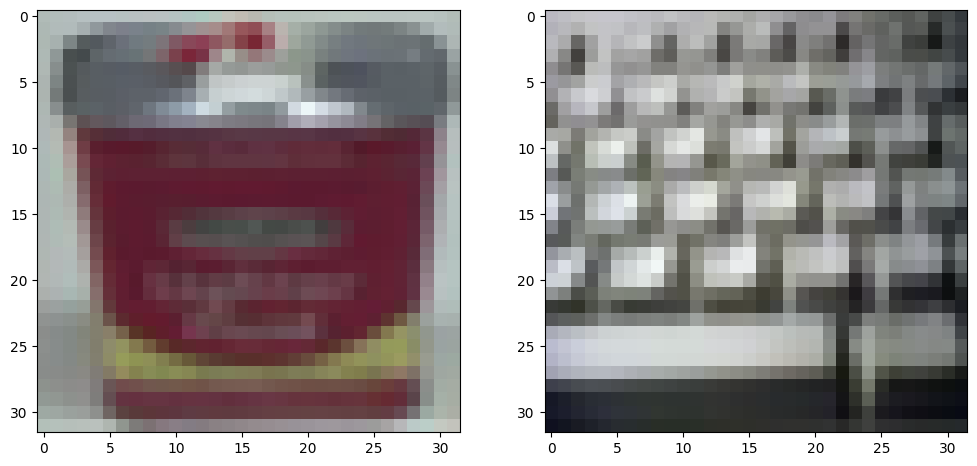

In [67]:
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

In [68]:
local_lr = 1e-4
local_steps = 5
use_updates = True

In [69]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_parameters = inversefed.reconstruction_algorithms.loss_steps(model, ground_truth, labels, 
                                                        lr=local_lr, local_steps=local_steps,
                                                                   use_updates=use_updates)
input_parameters = [p.detach() for p in input_parameters]

It: 0. Rec. loss: 0.0526.
It: 500. Rec. loss: 0.0083.
It: 1000. Rec. loss: 0.0088.
It: 1500. Rec. loss: 0.0065.
It: 2000. Rec. loss: 0.0074.
It: 2500. Rec. loss: 0.0104.
It: 3000. Rec. loss: 0.0090.
It: 3500. Rec. loss: 0.0077.
It: 4000. Rec. loss: 0.0068.
It: 4500. Rec. loss: 0.0060.
It: 5000. Rec. loss: 0.0071.
It: 5500. Rec. loss: 0.0070.
It: 6000. Rec. loss: 0.0055.
It: 6500. Rec. loss: 0.0065.
It: 7000. Rec. loss: 0.0067.
It: 7500. Rec. loss: 0.0077.
It: 7999. Rec. loss: 0.0070.
Choosing optimal result ...
Optimal result score: 0.0070
Total time: 1388.646330833435.


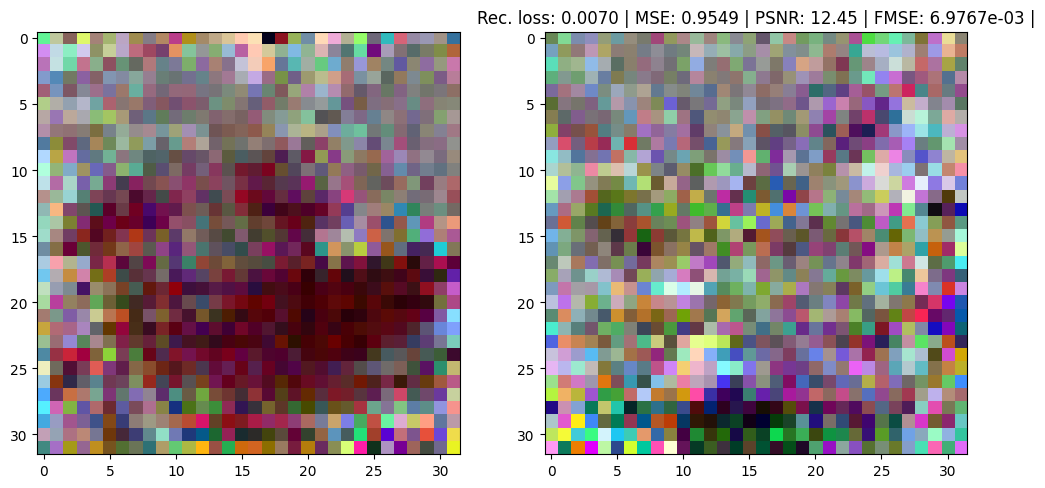

In [70]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=0.1,
              optim='adam',
              restarts=1,
              max_iterations=8_000,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

rec_machine = inversefed.FedAvgReconstructor(model, (dm, ds), local_steps, local_lr, config,
                                             use_updates=use_updates, num_images = labels.size(0))
output, stats = rec_machine.reconstruct(input_parameters, labels, img_shape=(3, 32, 32))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

In [71]:
stats

defaultdict(list, {'opt': 0.007006704807281494})

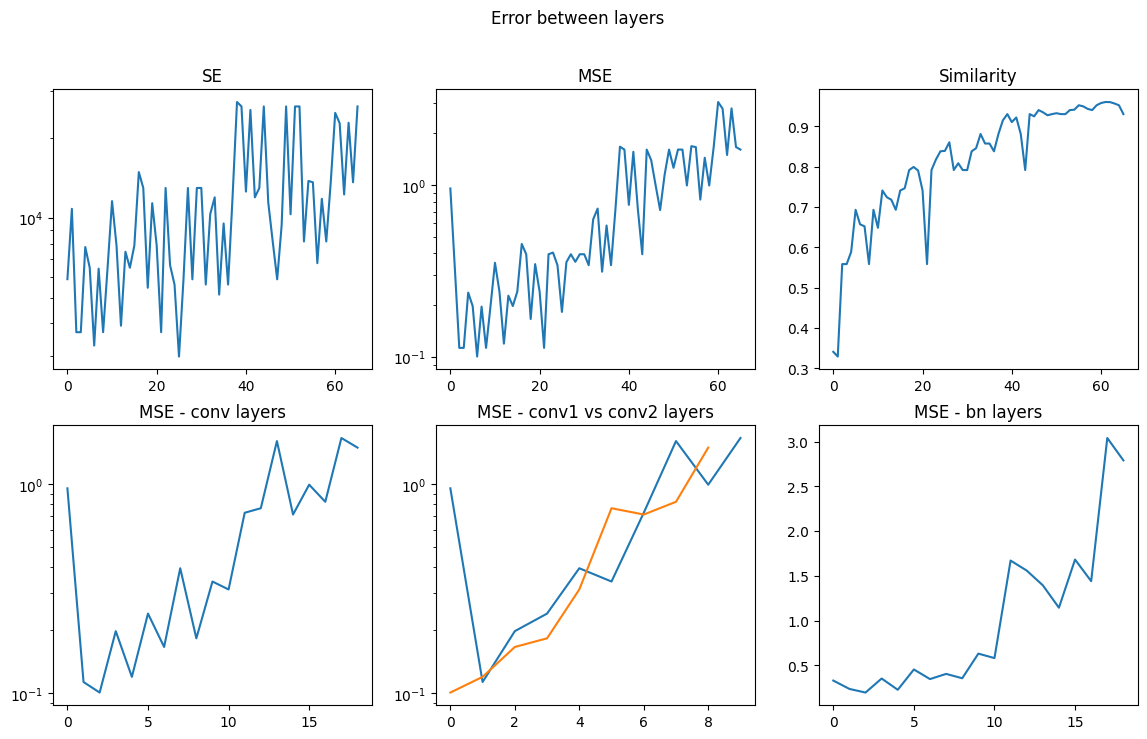

In [72]:
data = inversefed.metrics.activation_errors(model, output, ground_truth)

fig, axes = plt.subplots(2, 3, sharey=False, figsize=(14,8))
axes[0, 0].semilogy(list(data['se'].values())[:-3])
axes[0, 0].set_title('SE')
axes[0, 1].semilogy(list(data['mse'].values())[:-3])
axes[0, 1].set_title('MSE')
axes[0, 2].plot(list(data['sim'].values())[:-3])
axes[0, 2].set_title('Similarity')

convs = [val for key, val in data['mse'].items() if 'conv' in key]
axes[1, 0].semilogy(convs)
axes[1, 0].set_title('MSE - conv layers')
convs = [val for key, val in data['mse'].items() if 'conv1' in key]
axes[1, 1].semilogy(convs)
convs = [val for key, val in data['mse'].items() if 'conv2' in key]
axes[1, 1].semilogy(convs)
axes[1, 1].set_title('MSE - conv1 vs conv2 layers')
bns = [val for key, val in data['mse'].items() if 'bn' in key]
axes[1, 2].plot(bns)
axes[1, 2].set_title('MSE - bn layers')
fig.suptitle('Error between layers');